In [1]:
import torch
import config
from model import unet,ResUNet  # Import your model architecture
from glob import glob
from torch.utils.data import DataLoader, Dataset
import rasterio
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd

 
# Move the model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (device)

Step 1: Set work directory
Workspace: /ddnA/work/jinikeda/ETC/DL/sat4cl/src
Step 2: Set configuration parameters
cpu


In [2]:
# Load the saved model weights

# Define the model architecture
model_name = 'resunet'
if model_name == 'unet':
    model = unet(num_bands=6, num_classes=3,dropout_prob=0.0).to(device) # Use U-net model
elif model_name == 'resunet':
    model = ResUNet(num_bands=6, num_classes=3).to(device) # Use ResUNet model
else:
    print("Model not found.")

trained_file = f'model/trained_model/{model_name}_trained_1_weights.pth'
if device.type == 'cpu':
    # Map to CPU
    model.load_state_dict(torch.load(trained_file, map_location=torch.device('cpu'),weights_only=True), strict=False)
else:
    # Load normally for GPU
    model.load_state_dict(torch.load(trained_file))

# Move the model to the selected device
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


In [3]:
print (model)

ResUNet(
  (input_layer): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (input_skip): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (residual_conv_1): ResidualConv(
    (conv_block): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv_skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [4]:
print (config.dir_s2)

/ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2


In [5]:
## --------- Validation data paths -------- #
paths_scene = sorted(glob(config.dir_s2 + '/val_scene/*')) 
print(len (paths_scene))  # number of validation scenes
i_valset = [i for i in range(len(paths_scene))]  # number of validation sites
paths_truth = [path_scene.replace('_scene/', '_labels/').replace('_6Bands', '').split('.')[0] + '_classified.tif'  for path_scene in paths_scene]
i_valset
paths_val_scene, paths_val_truth = [paths_scene[i] for i in i_valset], [paths_truth[i] for i in i_valset]
site = int(0)
print(paths_val_scene[site])
print(paths_val_truth[site])
print('Number of val scenes:', len(paths_val_scene))
print('Number of total scenes:', len(paths_scene))

31
/ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190318_N0211_R061_6Bands_S1.tif
/ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190318_N0211_R061_S1_classified.tif
Number of val scenes: 31
Number of total scenes: 31


In [6]:
df =pd.read_csv("Trained_bands_mean_std.csv")
mean_list=df["Mean"].tolist() 
std_list=df["Std"].tolist() 

Index: 0
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190318_N0211_R061_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190318_N0211_R061_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 697, 754])
Original Truth Tensor Shape: torch.Size([1, 1, 697, 754])
Target Crop Dimensions: Height=688, Width=752
Cropped Scene Tensor Shape: torch.Size([1, 6, 688, 752])
Cropped Truth Tensor Shape: torch.Size([1, 1, 688, 752])
Prediction Tensor Shape: torch.Size([1, 3, 688, 752])
Final Prediction Shape: (688, 752)
Final Truth Shape: (688, 752)


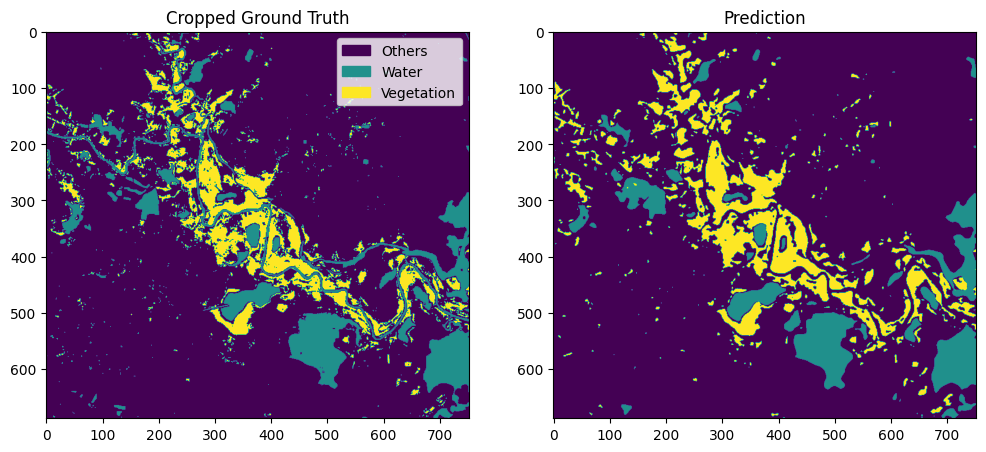

Index: 1
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190318_N0211_R061_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190318_N0211_R061_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 711, 760])
Original Truth Tensor Shape: torch.Size([1, 1, 711, 760])
Target Crop Dimensions: Height=704, Width=752
Cropped Scene Tensor Shape: torch.Size([1, 6, 704, 752])
Cropped Truth Tensor Shape: torch.Size([1, 1, 704, 752])
Prediction Tensor Shape: torch.Size([1, 3, 704, 752])
Final Prediction Shape: (704, 752)
Final Truth Shape: (704, 752)


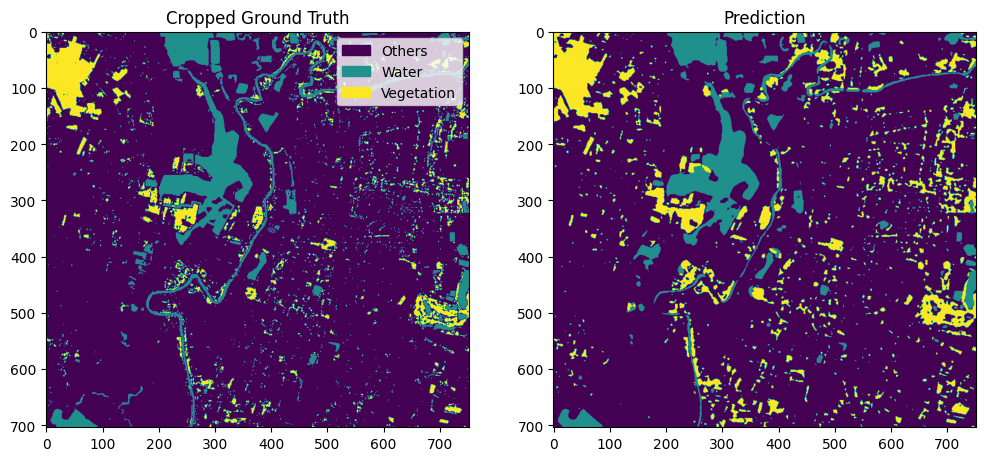

Index: 2
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190318_N0211_R061_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190318_N0211_R061_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 863, 886])
Original Truth Tensor Shape: torch.Size([1, 1, 863, 886])
Target Crop Dimensions: Height=848, Width=880
Cropped Scene Tensor Shape: torch.Size([1, 6, 848, 880])
Cropped Truth Tensor Shape: torch.Size([1, 1, 848, 880])
Prediction Tensor Shape: torch.Size([1, 3, 848, 880])
Final Prediction Shape: (848, 880)
Final Truth Shape: (848, 880)


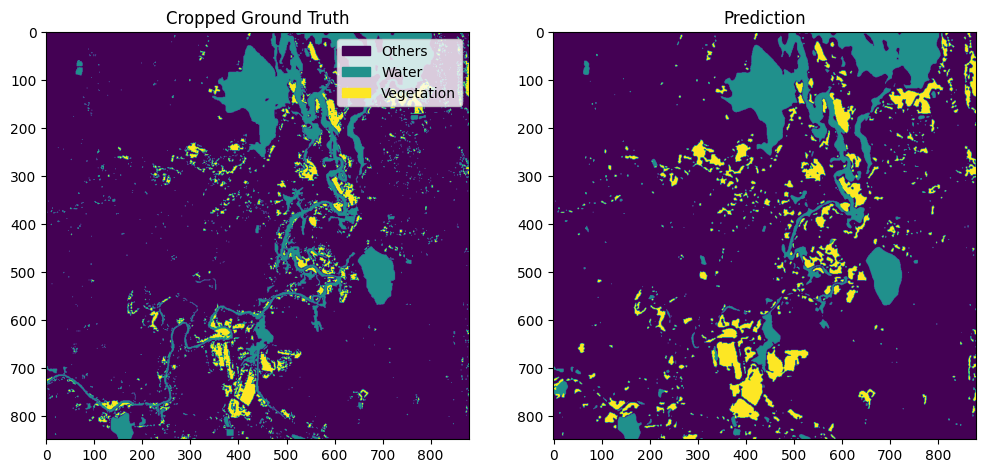

Index: 3
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190426_N0211_R053_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190426_N0211_R053_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 575, 689])
Original Truth Tensor Shape: torch.Size([1, 1, 575, 689])
Target Crop Dimensions: Height=560, Width=688
Cropped Scene Tensor Shape: torch.Size([1, 6, 560, 688])
Cropped Truth Tensor Shape: torch.Size([1, 1, 560, 688])
Prediction Tensor Shape: torch.Size([1, 3, 560, 688])
Final Prediction Shape: (560, 688)
Final Truth Shape: (560, 688)


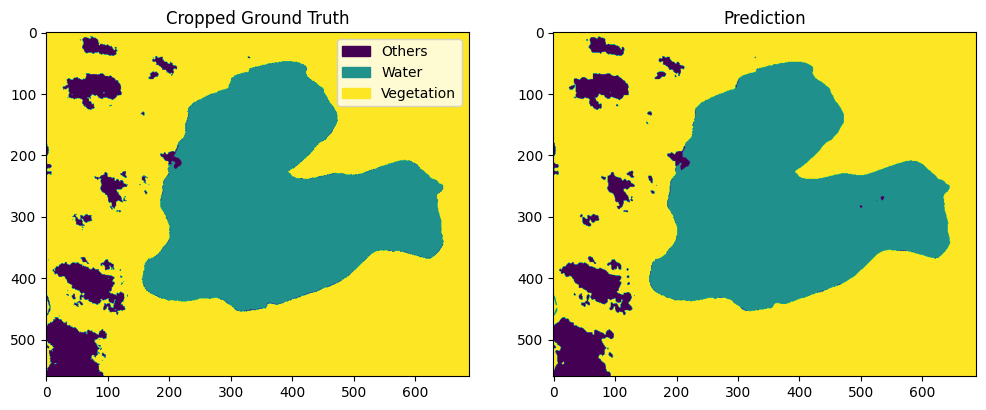

Index: 4
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190426_N0211_R053_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190426_N0211_R053_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 898, 993])
Original Truth Tensor Shape: torch.Size([1, 1, 898, 993])
Target Crop Dimensions: Height=896, Width=992
Cropped Scene Tensor Shape: torch.Size([1, 6, 896, 992])
Cropped Truth Tensor Shape: torch.Size([1, 1, 896, 992])
Prediction Tensor Shape: torch.Size([1, 3, 896, 992])
Final Prediction Shape: (896, 992)
Final Truth Shape: (896, 992)


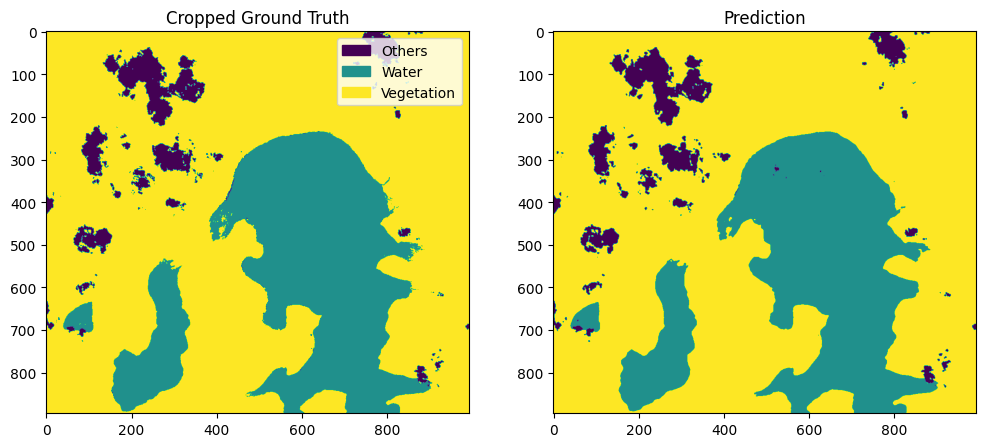

Index: 5
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190426_N0211_R053_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190426_N0211_R053_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 745, 840])
Original Truth Tensor Shape: torch.Size([1, 1, 745, 840])
Target Crop Dimensions: Height=736, Width=832
Cropped Scene Tensor Shape: torch.Size([1, 6, 736, 832])
Cropped Truth Tensor Shape: torch.Size([1, 1, 736, 832])
Prediction Tensor Shape: torch.Size([1, 3, 736, 832])
Final Prediction Shape: (736, 832)
Final Truth Shape: (736, 832)


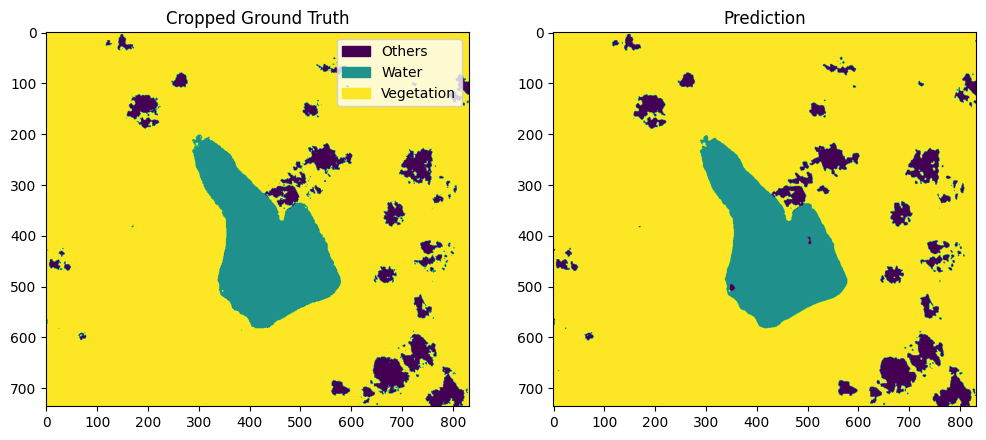

Index: 6
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190429_N0211_R096_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190429_N0211_R096_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 910, 986])
Original Truth Tensor Shape: torch.Size([1, 1, 910, 986])
Target Crop Dimensions: Height=896, Width=976
Cropped Scene Tensor Shape: torch.Size([1, 6, 896, 976])
Cropped Truth Tensor Shape: torch.Size([1, 1, 896, 976])
Prediction Tensor Shape: torch.Size([1, 3, 896, 976])
Final Prediction Shape: (896, 976)
Final Truth Shape: (896, 976)


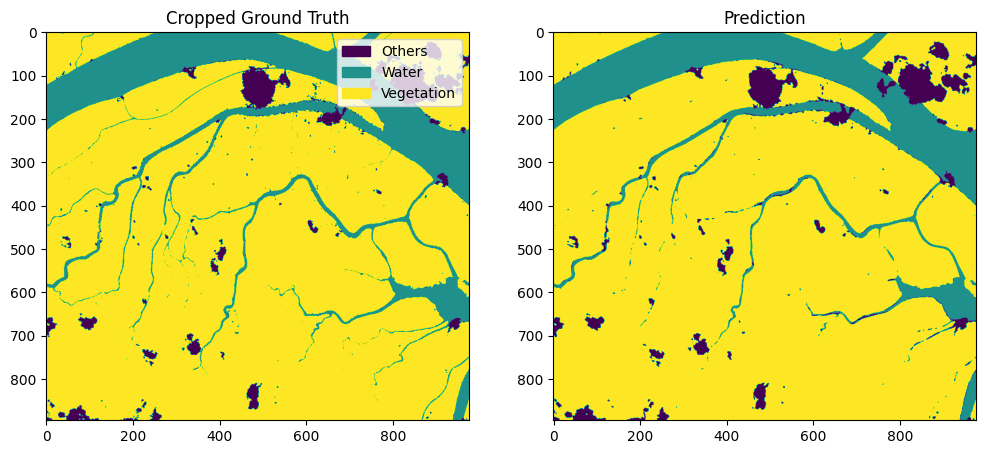

Index: 7
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190429_N0211_R096_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190429_N0211_R096_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 837, 898])
Original Truth Tensor Shape: torch.Size([1, 1, 837, 898])
Target Crop Dimensions: Height=832, Width=896
Cropped Scene Tensor Shape: torch.Size([1, 6, 832, 896])
Cropped Truth Tensor Shape: torch.Size([1, 1, 832, 896])
Prediction Tensor Shape: torch.Size([1, 3, 832, 896])
Final Prediction Shape: (832, 896)
Final Truth Shape: (832, 896)


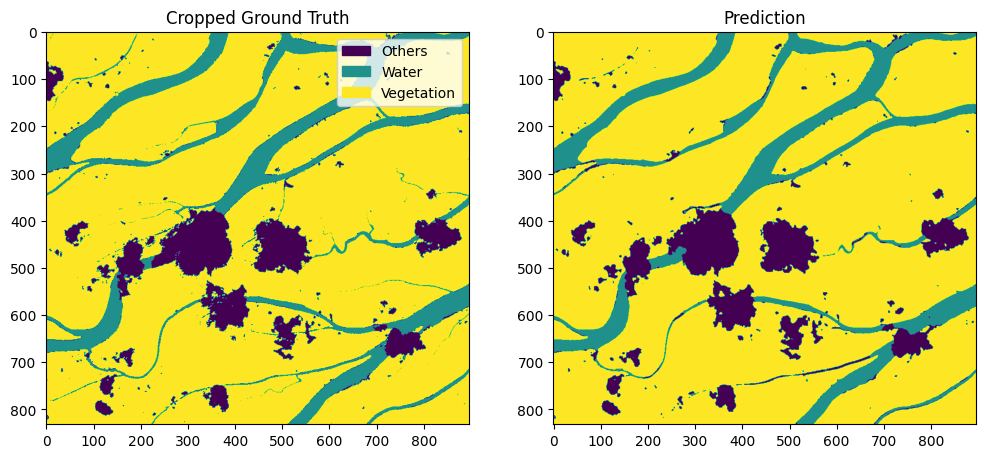

Index: 8
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190429_N0211_R096_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190429_N0211_R096_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 863, 911])
Original Truth Tensor Shape: torch.Size([1, 1, 863, 911])
Target Crop Dimensions: Height=848, Width=896
Cropped Scene Tensor Shape: torch.Size([1, 6, 848, 896])
Cropped Truth Tensor Shape: torch.Size([1, 1, 848, 896])
Prediction Tensor Shape: torch.Size([1, 3, 848, 896])
Final Prediction Shape: (848, 896)
Final Truth Shape: (848, 896)


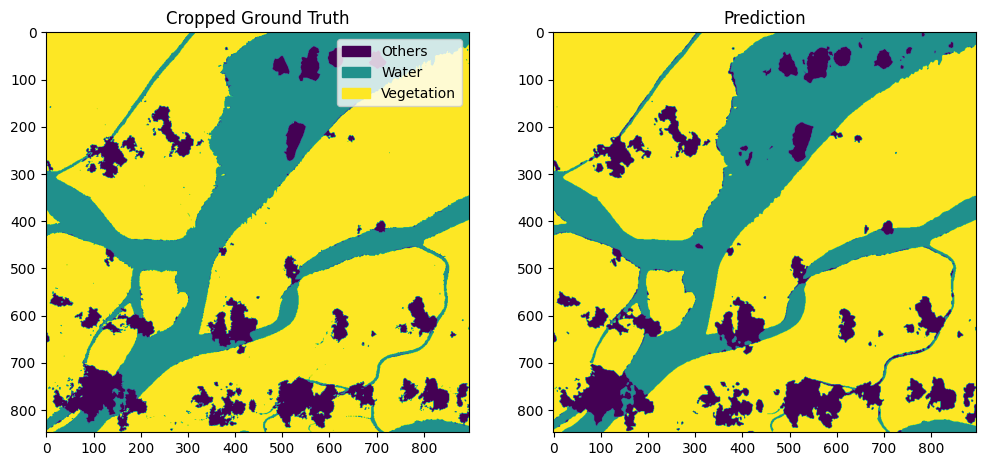

Index: 9
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190508_N0212_R078_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190508_N0212_R078_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 916, 987])
Original Truth Tensor Shape: torch.Size([1, 1, 916, 987])
Target Crop Dimensions: Height=912, Width=976
Cropped Scene Tensor Shape: torch.Size([1, 6, 912, 976])
Cropped Truth Tensor Shape: torch.Size([1, 1, 912, 976])
Prediction Tensor Shape: torch.Size([1, 3, 912, 976])
Final Prediction Shape: (912, 976)
Final Truth Shape: (912, 976)


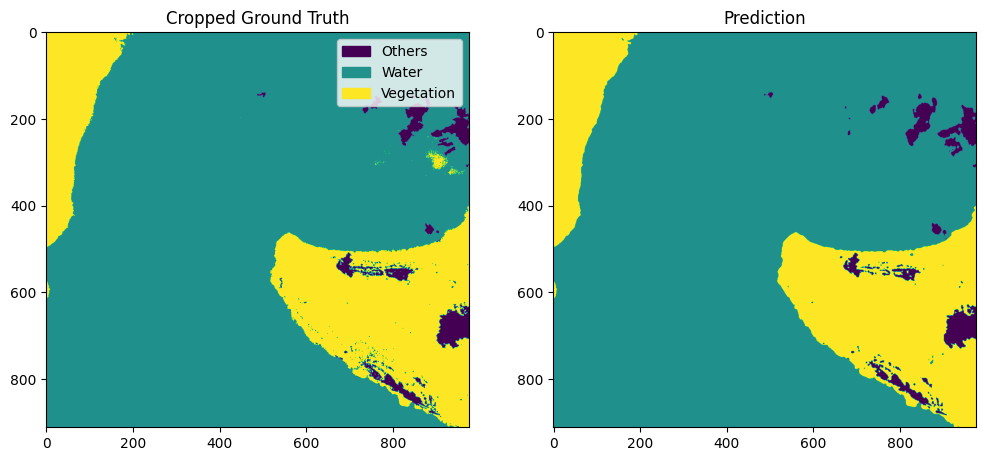

Index: 10
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190508_N0212_R078_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190508_N0212_R078_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 691, 752])
Original Truth Tensor Shape: torch.Size([1, 1, 691, 752])
Target Crop Dimensions: Height=688, Width=752
Cropped Scene Tensor Shape: torch.Size([1, 6, 688, 752])
Cropped Truth Tensor Shape: torch.Size([1, 1, 688, 752])
Prediction Tensor Shape: torch.Size([1, 3, 688, 752])
Final Prediction Shape: (688, 752)
Final Truth Shape: (688, 752)


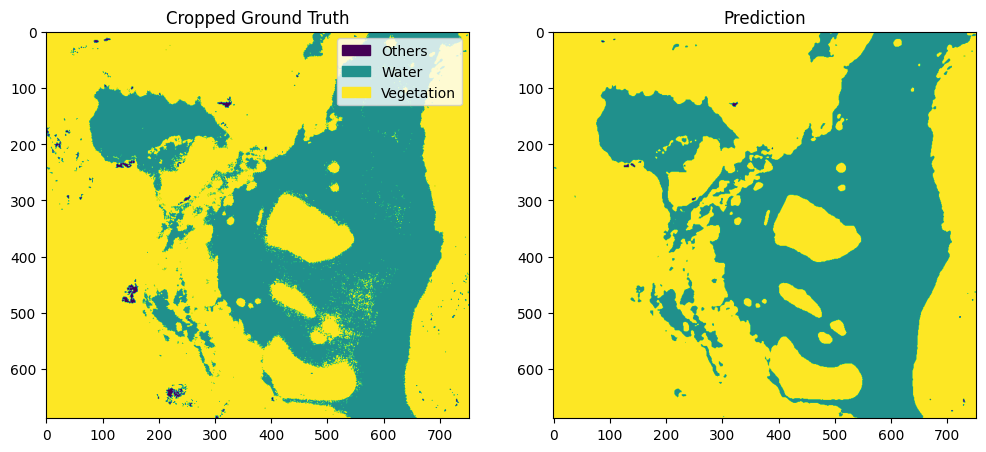

Index: 11
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190508_N0212_R078_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190508_N0212_R078_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 682, 807])
Original Truth Tensor Shape: torch.Size([1, 1, 682, 807])
Target Crop Dimensions: Height=672, Width=800
Cropped Scene Tensor Shape: torch.Size([1, 6, 672, 800])
Cropped Truth Tensor Shape: torch.Size([1, 1, 672, 800])
Prediction Tensor Shape: torch.Size([1, 3, 672, 800])
Final Prediction Shape: (672, 800)
Final Truth Shape: (672, 800)


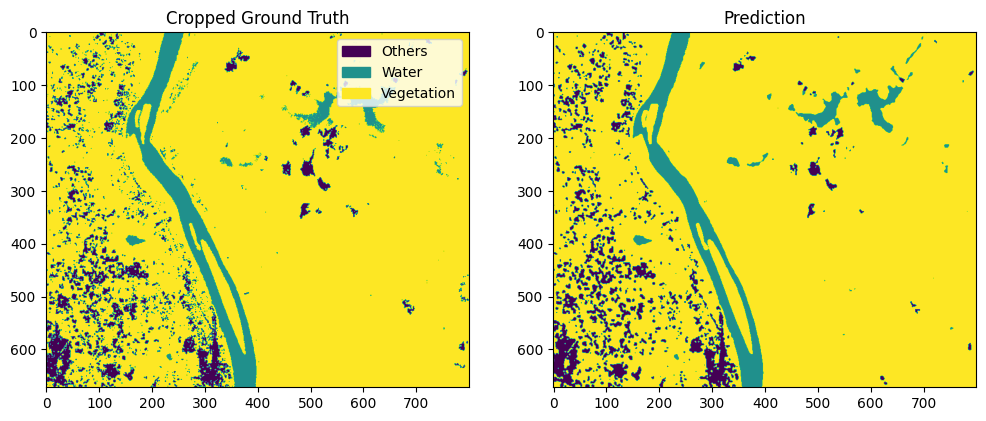

Index: 12
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190518_N0212_R073_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190518_N0212_R073_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 878, 948])
Original Truth Tensor Shape: torch.Size([1, 1, 878, 948])
Target Crop Dimensions: Height=864, Width=944
Cropped Scene Tensor Shape: torch.Size([1, 6, 864, 944])
Cropped Truth Tensor Shape: torch.Size([1, 1, 864, 944])
Prediction Tensor Shape: torch.Size([1, 3, 864, 944])
Final Prediction Shape: (864, 944)
Final Truth Shape: (864, 944)


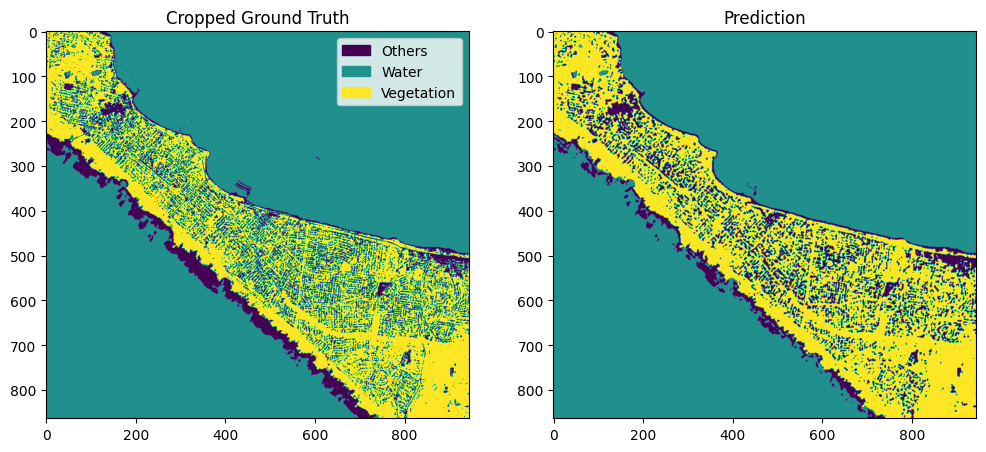

Index: 13
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190518_N0212_R073_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190518_N0212_R073_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 806, 853])
Original Truth Tensor Shape: torch.Size([1, 1, 806, 853])
Target Crop Dimensions: Height=800, Width=848
Cropped Scene Tensor Shape: torch.Size([1, 6, 800, 848])
Cropped Truth Tensor Shape: torch.Size([1, 1, 800, 848])
Prediction Tensor Shape: torch.Size([1, 3, 800, 848])
Final Prediction Shape: (800, 848)
Final Truth Shape: (800, 848)


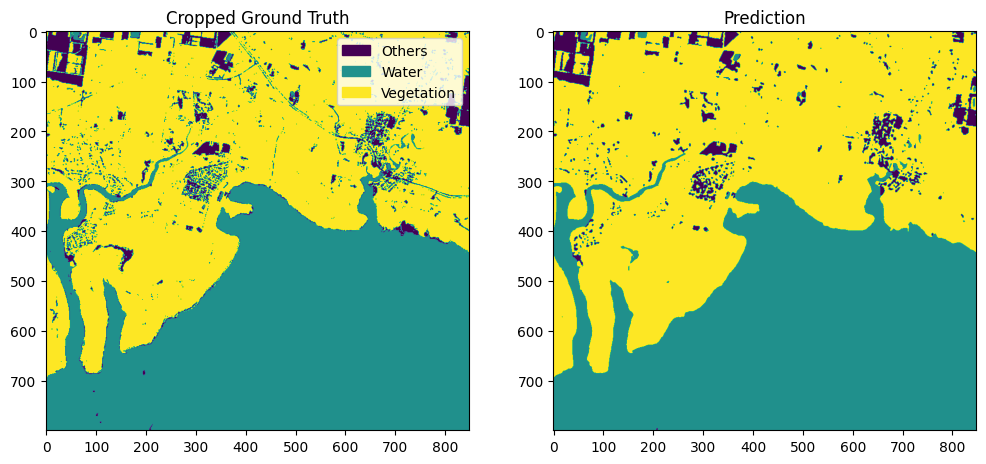

Index: 14
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190518_N0212_R073_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190518_N0212_R073_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 745, 825])
Original Truth Tensor Shape: torch.Size([1, 1, 745, 825])
Target Crop Dimensions: Height=736, Width=816
Cropped Scene Tensor Shape: torch.Size([1, 6, 736, 816])
Cropped Truth Tensor Shape: torch.Size([1, 1, 736, 816])
Prediction Tensor Shape: torch.Size([1, 3, 736, 816])
Final Prediction Shape: (736, 816)
Final Truth Shape: (736, 816)


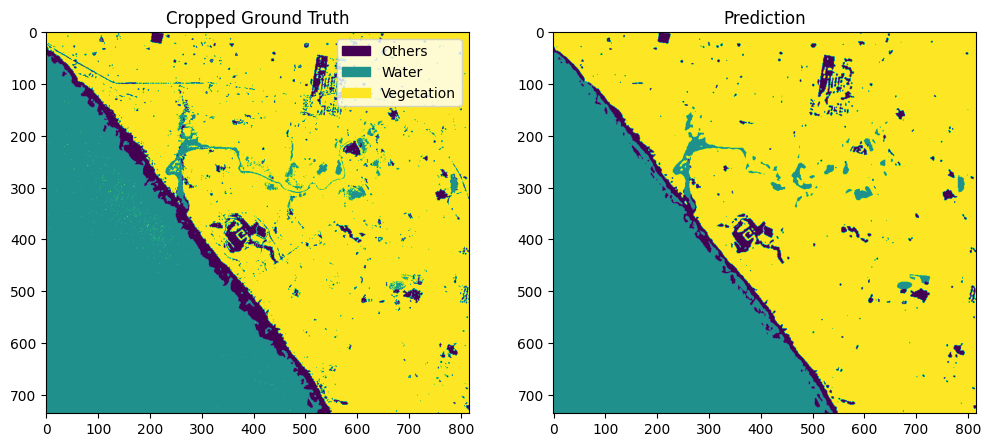

Index: 15
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190724_N0213_R033_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190724_N0213_R033_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 1037, 1130])
Original Truth Tensor Shape: torch.Size([1, 1, 1037, 1130])
Target Crop Dimensions: Height=1024, Width=1120
Cropped Scene Tensor Shape: torch.Size([1, 6, 1024, 1120])
Cropped Truth Tensor Shape: torch.Size([1, 1, 1024, 1120])
Prediction Tensor Shape: torch.Size([1, 3, 1024, 1120])
Final Prediction Shape: (1024, 1120)
Final Truth Shape: (1024, 1120)


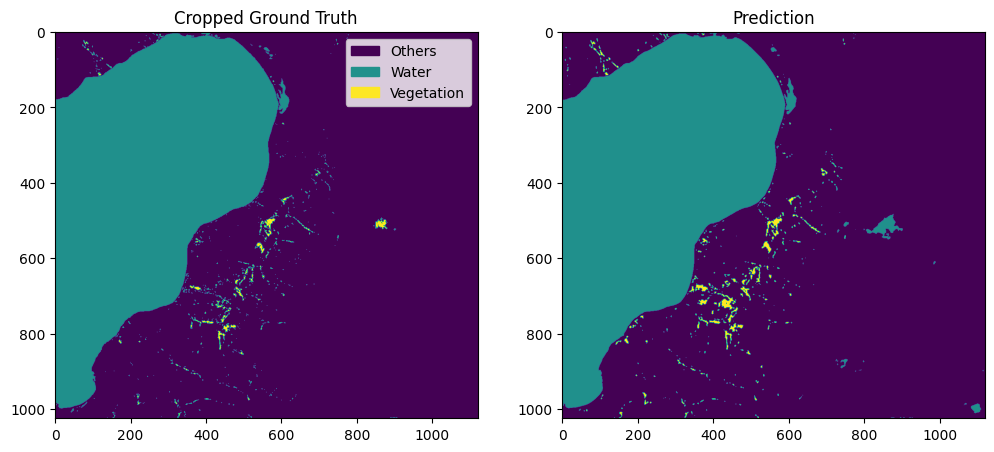

Index: 16
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190724_N0213_R033_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190724_N0213_R033_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 893, 958])
Original Truth Tensor Shape: torch.Size([1, 1, 893, 958])
Target Crop Dimensions: Height=880, Width=944
Cropped Scene Tensor Shape: torch.Size([1, 6, 880, 944])
Cropped Truth Tensor Shape: torch.Size([1, 1, 880, 944])
Prediction Tensor Shape: torch.Size([1, 3, 880, 944])
Final Prediction Shape: (880, 944)
Final Truth Shape: (880, 944)


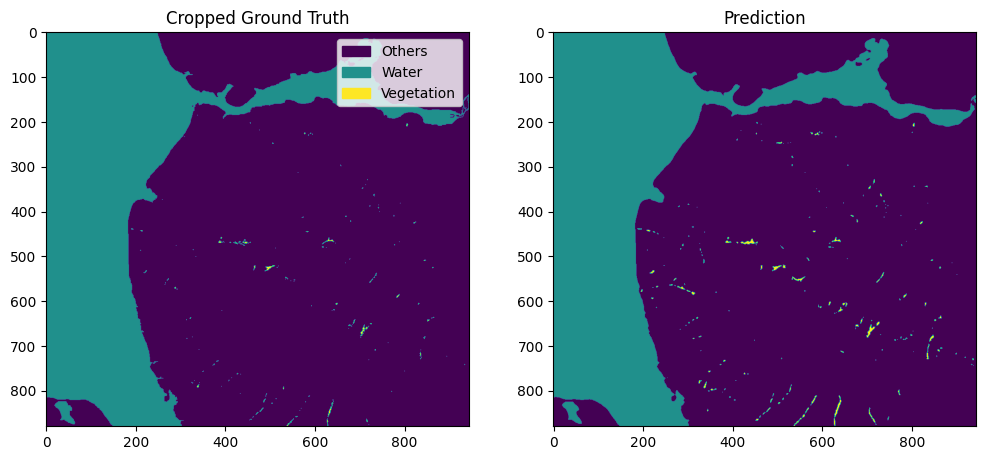

Index: 17
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190724_N0213_R033_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190724_N0213_R033_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 984, 1027])
Original Truth Tensor Shape: torch.Size([1, 1, 984, 1027])
Target Crop Dimensions: Height=976, Width=1024
Cropped Scene Tensor Shape: torch.Size([1, 6, 976, 1024])
Cropped Truth Tensor Shape: torch.Size([1, 1, 976, 1024])
Prediction Tensor Shape: torch.Size([1, 3, 976, 1024])
Final Prediction Shape: (976, 1024)
Final Truth Shape: (976, 1024)


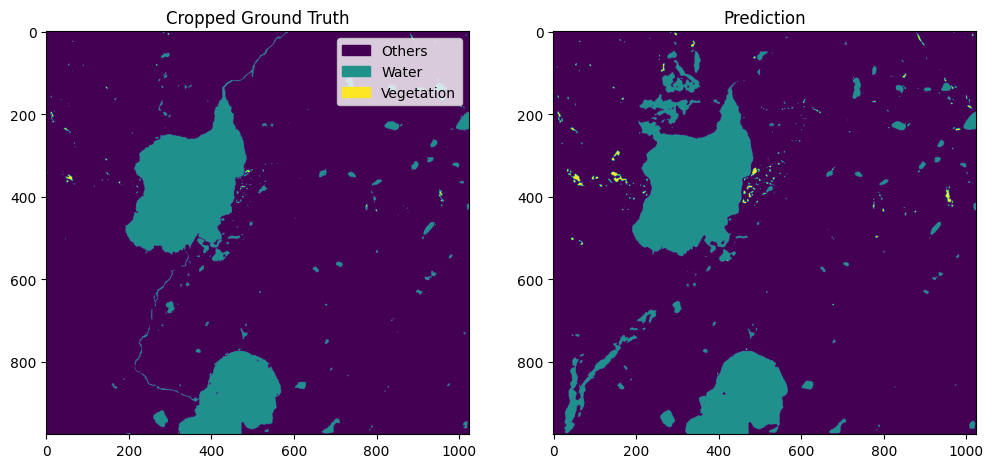

Index: 18
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190725_N0213_R054_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190725_N0213_R054_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 601, 686])
Original Truth Tensor Shape: torch.Size([1, 1, 601, 686])
Target Crop Dimensions: Height=592, Width=672
Cropped Scene Tensor Shape: torch.Size([1, 6, 592, 672])
Cropped Truth Tensor Shape: torch.Size([1, 1, 592, 672])
Prediction Tensor Shape: torch.Size([1, 3, 592, 672])
Final Prediction Shape: (592, 672)
Final Truth Shape: (592, 672)


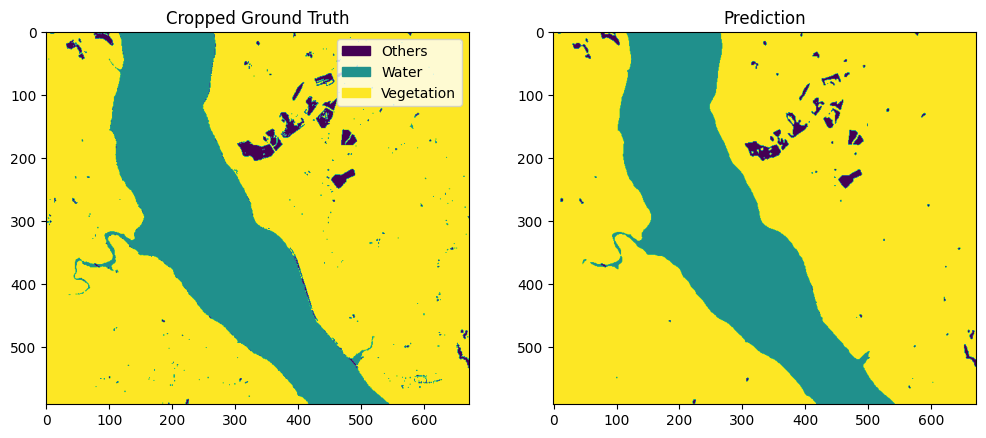

Index: 19
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190725_N0213_R054_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190725_N0213_R054_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 596, 623])
Original Truth Tensor Shape: torch.Size([1, 1, 596, 623])
Target Crop Dimensions: Height=592, Width=608
Cropped Scene Tensor Shape: torch.Size([1, 6, 592, 608])
Cropped Truth Tensor Shape: torch.Size([1, 1, 592, 608])
Prediction Tensor Shape: torch.Size([1, 3, 592, 608])
Final Prediction Shape: (592, 608)
Final Truth Shape: (592, 608)


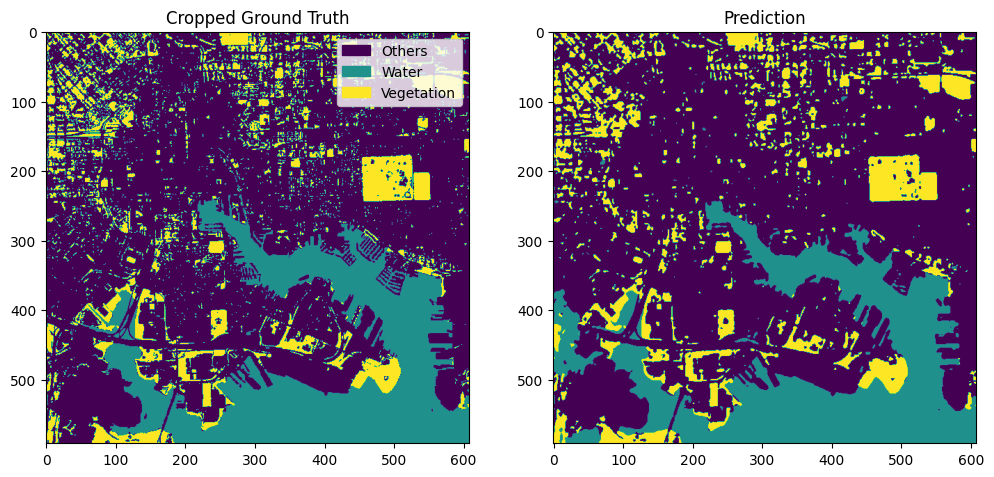

Index: 20
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190725_N0213_R054_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190725_N0213_R054_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 586, 647])
Original Truth Tensor Shape: torch.Size([1, 1, 586, 647])
Target Crop Dimensions: Height=576, Width=640
Cropped Scene Tensor Shape: torch.Size([1, 6, 576, 640])
Cropped Truth Tensor Shape: torch.Size([1, 1, 576, 640])
Prediction Tensor Shape: torch.Size([1, 3, 576, 640])
Final Prediction Shape: (576, 640)
Final Truth Shape: (576, 640)


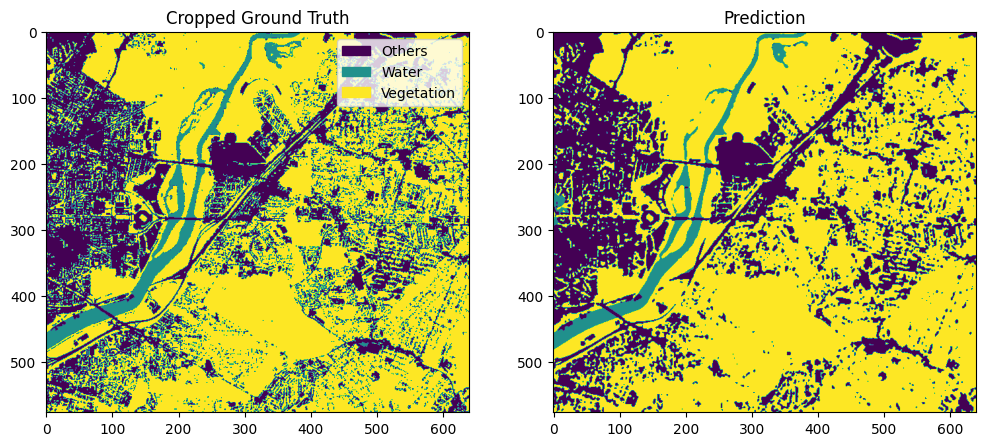

Index: 21
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2A_L2A_20190725_N0213_R054_6Bands_S4.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2A_L2A_20190725_N0213_R054_S4_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 642, 731])
Original Truth Tensor Shape: torch.Size([1, 1, 642, 731])
Target Crop Dimensions: Height=640, Width=720
Cropped Scene Tensor Shape: torch.Size([1, 6, 640, 720])
Cropped Truth Tensor Shape: torch.Size([1, 1, 640, 720])
Prediction Tensor Shape: torch.Size([1, 3, 640, 720])
Final Prediction Shape: (640, 720)
Final Truth Shape: (640, 720)


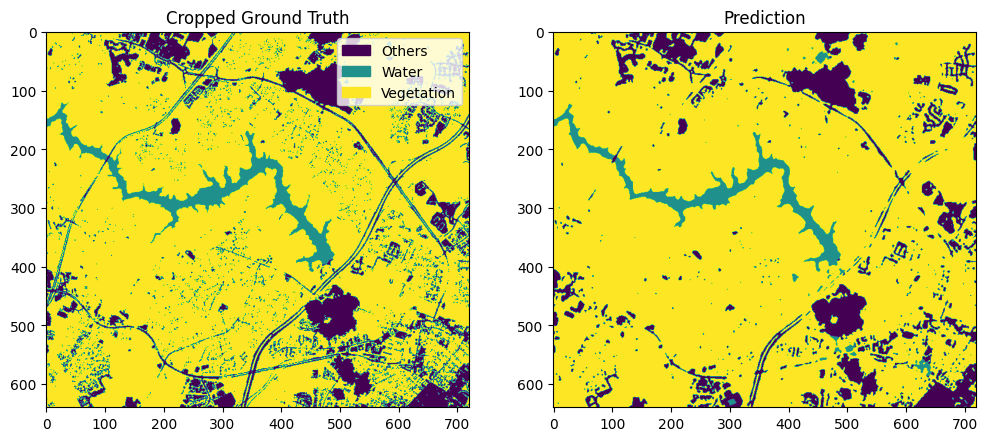

Index: 22
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20190303_N0211_R065_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20190303_N0211_R065_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 1019, 1071])
Original Truth Tensor Shape: torch.Size([1, 1, 1019, 1071])
Target Crop Dimensions: Height=1008, Width=1056
Cropped Scene Tensor Shape: torch.Size([1, 6, 1008, 1056])
Cropped Truth Tensor Shape: torch.Size([1, 1, 1008, 1056])
Prediction Tensor Shape: torch.Size([1, 3, 1008, 1056])
Final Prediction Shape: (1008, 1056)
Final Truth Shape: (1008, 1056)


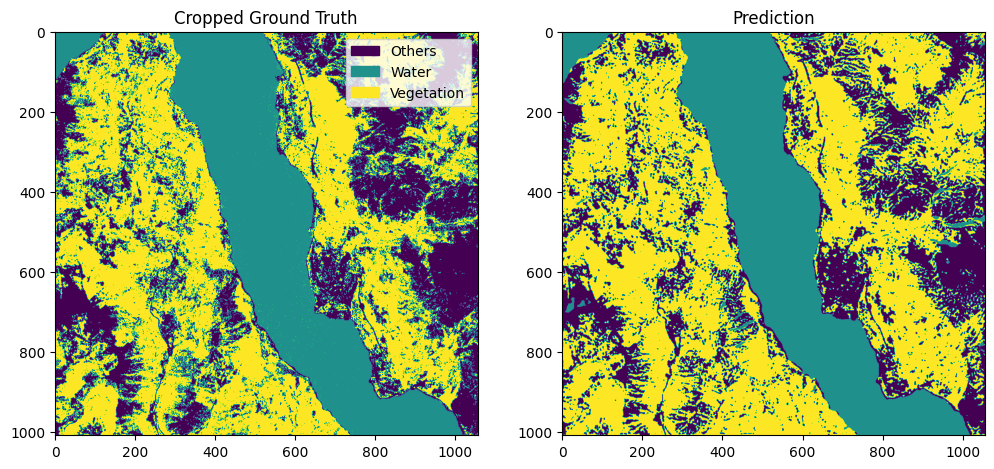

Index: 23
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20190303_N0211_R065_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20190303_N0211_R065_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 930, 970])
Original Truth Tensor Shape: torch.Size([1, 1, 930, 970])
Target Crop Dimensions: Height=928, Width=960
Cropped Scene Tensor Shape: torch.Size([1, 6, 928, 960])
Cropped Truth Tensor Shape: torch.Size([1, 1, 928, 960])
Prediction Tensor Shape: torch.Size([1, 3, 928, 960])
Final Prediction Shape: (928, 960)
Final Truth Shape: (928, 960)


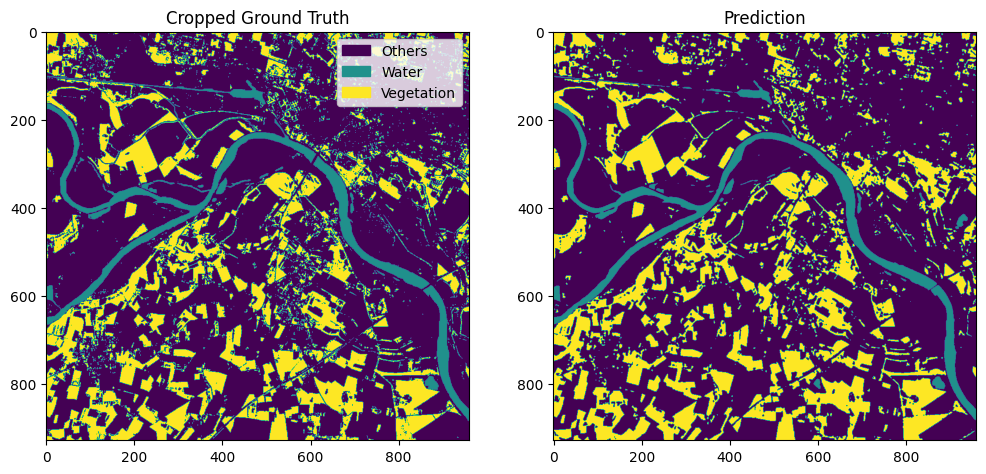

Index: 24
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20190303_N0211_R065_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20190303_N0211_R065_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 937, 1036])
Original Truth Tensor Shape: torch.Size([1, 1, 937, 1036])
Target Crop Dimensions: Height=928, Width=1024
Cropped Scene Tensor Shape: torch.Size([1, 6, 928, 1024])
Cropped Truth Tensor Shape: torch.Size([1, 1, 928, 1024])
Prediction Tensor Shape: torch.Size([1, 3, 928, 1024])
Final Prediction Shape: (928, 1024)
Final Truth Shape: (928, 1024)


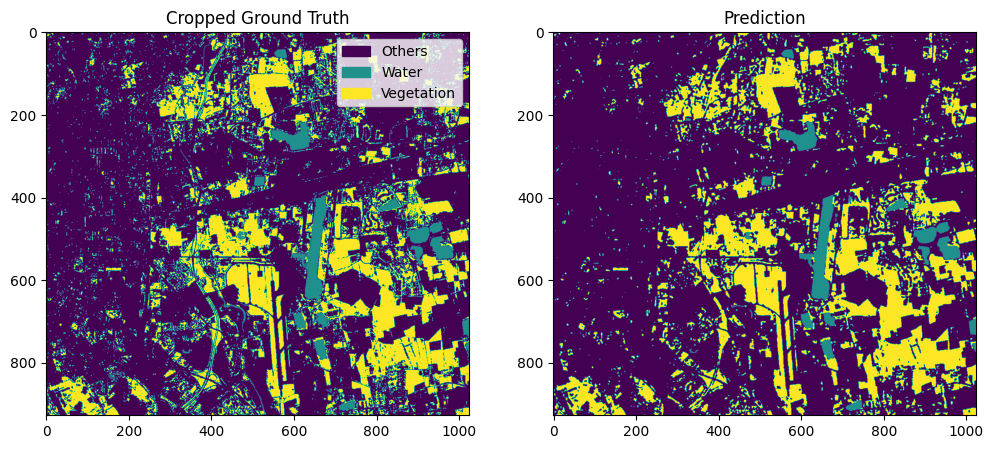

Index: 25
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20190620_N0212_R047_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20190620_N0212_R047_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 1246, 1351])
Original Truth Tensor Shape: torch.Size([1, 1, 1246, 1351])
Target Crop Dimensions: Height=1232, Width=1344
Cropped Scene Tensor Shape: torch.Size([1, 6, 1232, 1344])
Cropped Truth Tensor Shape: torch.Size([1, 1, 1232, 1344])
Prediction Tensor Shape: torch.Size([1, 3, 1232, 1344])
Final Prediction Shape: (1232, 1344)
Final Truth Shape: (1232, 1344)


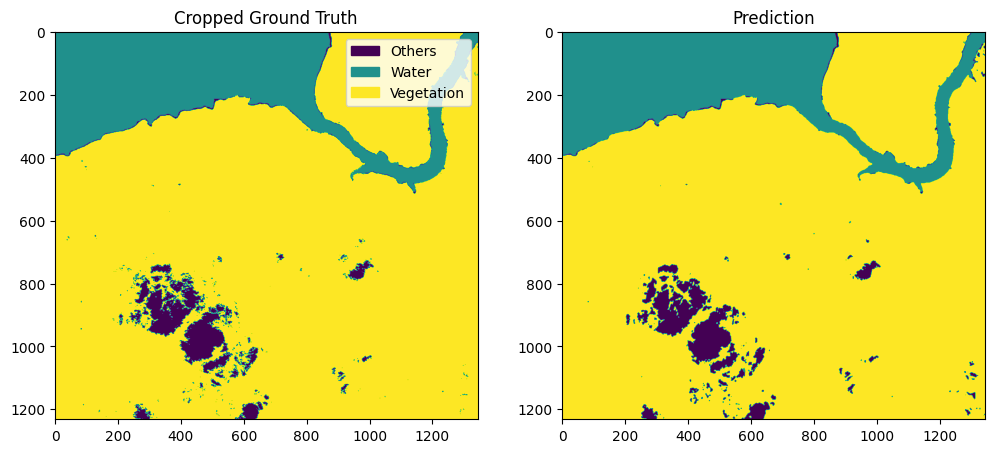

Index: 26
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20190620_N0212_R047_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20190620_N0212_R047_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 1416, 1463])
Original Truth Tensor Shape: torch.Size([1, 1, 1416, 1463])
Target Crop Dimensions: Height=1408, Width=1456
Cropped Scene Tensor Shape: torch.Size([1, 6, 1408, 1456])
Cropped Truth Tensor Shape: torch.Size([1, 1, 1408, 1456])
Prediction Tensor Shape: torch.Size([1, 3, 1408, 1456])
Final Prediction Shape: (1408, 1456)
Final Truth Shape: (1408, 1456)


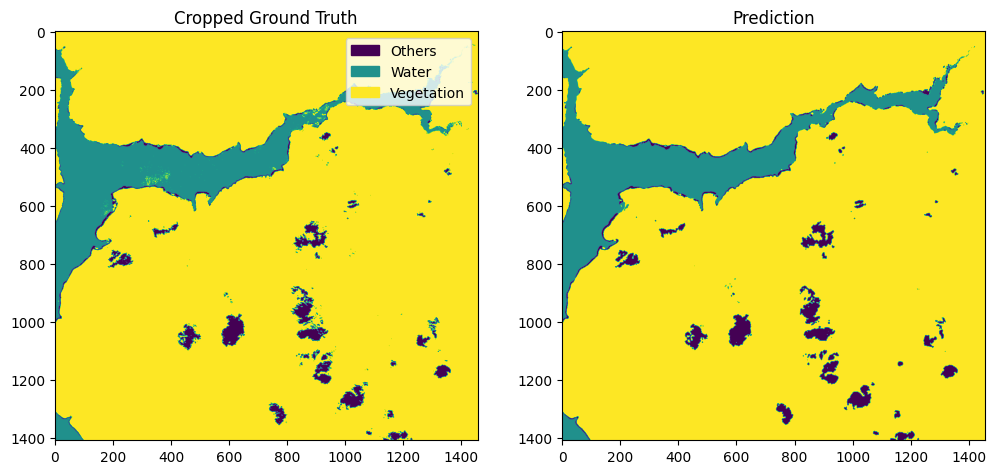

Index: 27
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20190620_N0212_R047_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20190620_N0212_R047_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 1398, 1547])
Original Truth Tensor Shape: torch.Size([1, 1, 1398, 1547])
Target Crop Dimensions: Height=1392, Width=1536
Cropped Scene Tensor Shape: torch.Size([1, 6, 1392, 1536])
Cropped Truth Tensor Shape: torch.Size([1, 1, 1392, 1536])
Prediction Tensor Shape: torch.Size([1, 3, 1392, 1536])
Final Prediction Shape: (1392, 1536)
Final Truth Shape: (1392, 1536)


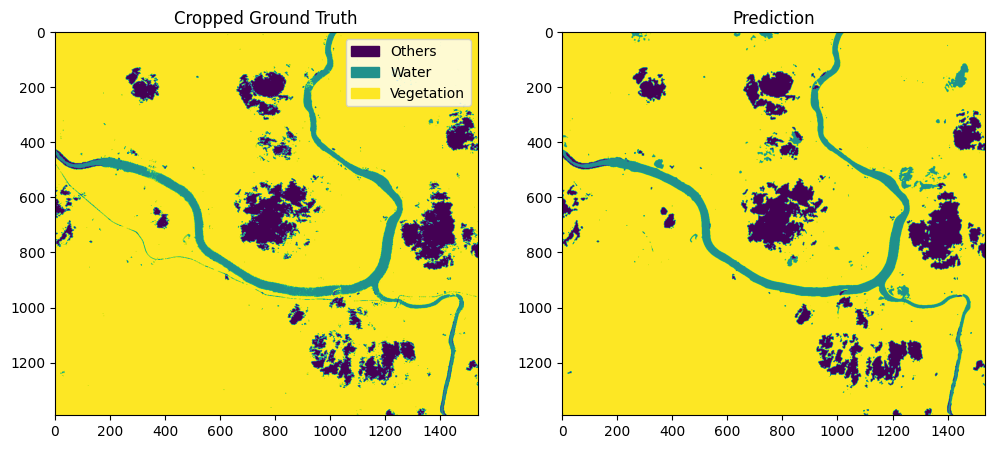

Index: 28
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20191015_N0213_R007_6Bands_S1.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20191015_N0213_R007_S1_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 1014, 1051])
Original Truth Tensor Shape: torch.Size([1, 1, 1014, 1051])
Target Crop Dimensions: Height=1008, Width=1040
Cropped Scene Tensor Shape: torch.Size([1, 6, 1008, 1040])
Cropped Truth Tensor Shape: torch.Size([1, 1, 1008, 1040])
Prediction Tensor Shape: torch.Size([1, 3, 1008, 1040])
Final Prediction Shape: (1008, 1040)
Final Truth Shape: (1008, 1040)


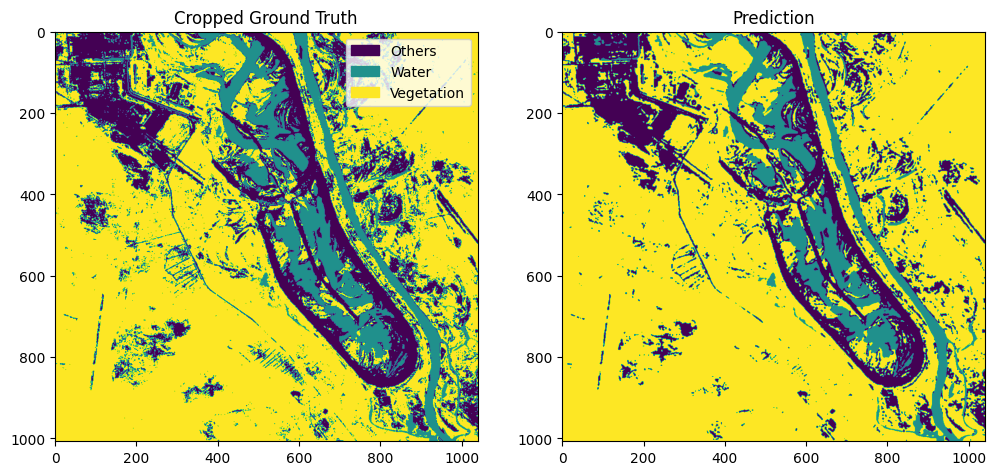

Index: 29
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20191015_N0213_R007_6Bands_S2.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20191015_N0213_R007_S2_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 935, 926])
Original Truth Tensor Shape: torch.Size([1, 1, 935, 926])
Target Crop Dimensions: Height=928, Width=912
Cropped Scene Tensor Shape: torch.Size([1, 6, 928, 912])
Cropped Truth Tensor Shape: torch.Size([1, 1, 928, 912])
Prediction Tensor Shape: torch.Size([1, 3, 928, 912])
Final Prediction Shape: (928, 912)
Final Truth Shape: (928, 912)


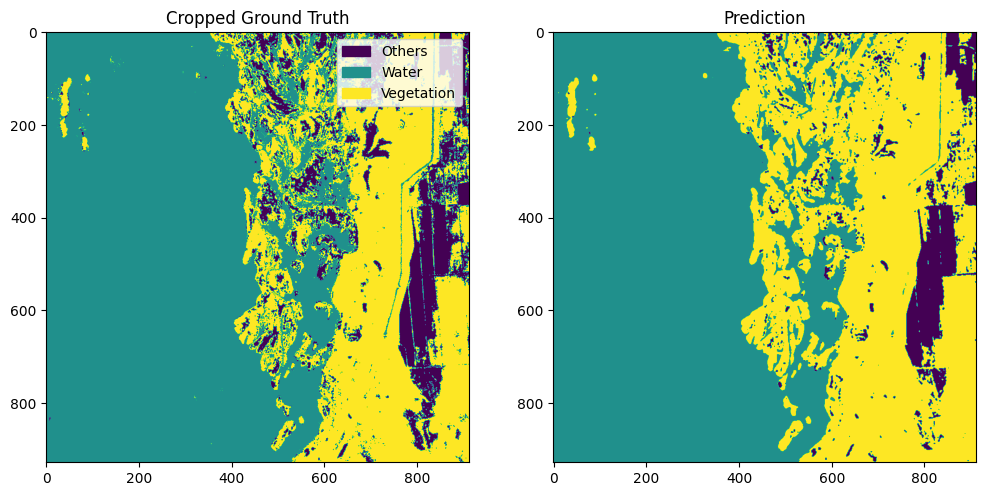

Index: 30
Scene: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_scene/S2B_L2A_20191015_N0213_R007_6Bands_S3.tif
Truth: /ddnA/work/jinikeda/ETC/DL/sat4cl/datasets/s2/val_labels/S2B_L2A_20191015_N0213_R007_S3_classified.tif
Original Scene Tensor Shape: torch.Size([1, 6, 1156, 1212])
Original Truth Tensor Shape: torch.Size([1, 1, 1156, 1212])
Target Crop Dimensions: Height=1152, Width=1200
Cropped Scene Tensor Shape: torch.Size([1, 6, 1152, 1200])
Cropped Truth Tensor Shape: torch.Size([1, 1, 1152, 1200])
Prediction Tensor Shape: torch.Size([1, 3, 1152, 1200])
Final Prediction Shape: (1152, 1200)
Final Truth Shape: (1152, 1200)


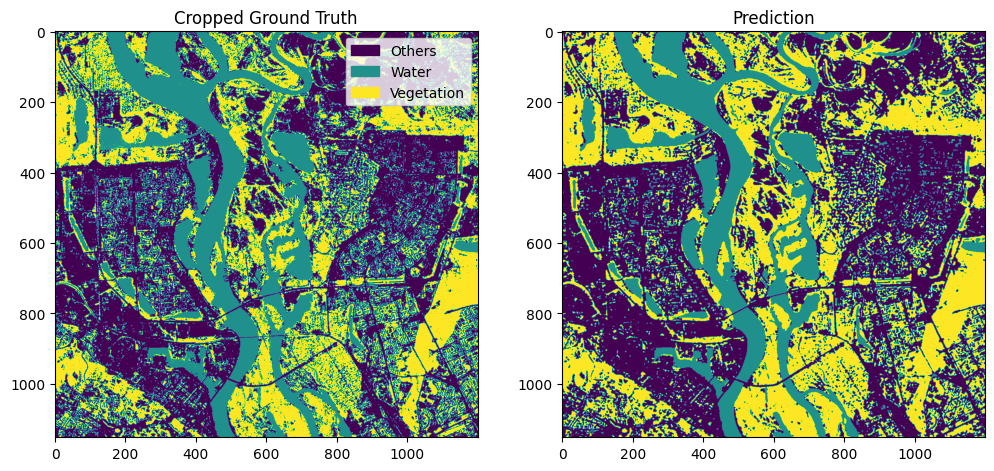

In [7]:
# Function to crop tensor to match target dimensions
def crop_to_match(tensor, target_height, target_width):
    """Crop a tensor to match the target height and width."""
    _, _, height, width = tensor.shape
    return tensor[:, :, :target_height, :target_width]

# Function to calculate top-left crop dimensions
def top_left_crop(tensor, target_height, target_width):
    """Crop a tensor to the target height and width from the top-left corner."""
    _, _, height, width = tensor.shape
    # Ensure the tensor size is large enough for the crop
    assert height >= target_height and width >= target_width, "Target dimensions exceed tensor size!"
    return tensor[:, :, :target_height, :target_width]

Workspace=os.getcwd() # HPC
Photospace=os.path.join(Workspace, 'Photo')

# Load and preprocess the input scene and ground truth
for index, (scene, truth) in enumerate(zip(paths_val_scene, paths_val_truth)):
    print(f"Index: {index}")
    print(f"Scene: {scene}")
    print(f"Truth: {truth}")

    # Open and check alignment
    with rasterio.open(scene) as scene_src, rasterio.open(truth) as truth_src:
        assert scene_src.crs == truth_src.crs, f"CRS mismatch: {scene_src.crs} vs {truth_src.crs}"
        assert scene_src.transform == truth_src.transform, f"Transform mismatch: {scene_src.transform} vs {truth_src.transform}"

        scene = scene_src.read()  # (bands, height, width)
        truth = truth_src.read(1)  # (height, width)

    # Normalize scene tensor
    scene_tensor = torch.tensor(scene, dtype=torch.float32).unsqueeze(0).to(device)
    bands_mean = torch.tensor(mean_list).view(1, -1, 1, 1).to(device)
    bands_std = torch.tensor(std_list).view(1, -1, 1, 1).to(device)
    scene_tensor = (scene_tensor - bands_mean) / bands_std

    # Prepare truth tensor
    truth_tensor = torch.tensor(truth, dtype=torch.long).unsqueeze(0).unsqueeze(1).to(device)

    # Log original dimensions
    print(f"Original Scene Tensor Shape: {scene_tensor.shape}")
    print(f"Original Truth Tensor Shape: {truth_tensor.shape}")

    # Calculate target crop dimensions
    original_height, original_width = scene_tensor.size(2), scene_tensor.size(3)
    target_height, target_width = (original_height // 16) * 16, (original_width // 16) * 16
    print(f"Target Crop Dimensions: Height={target_height}, Width={target_width}")

    # Apply top-left cropping
    scene_tensor = top_left_crop(scene_tensor, target_height, target_width)
    truth_tensor = top_left_crop(truth_tensor, target_height, target_width)

    # Log cropped dimensions
    print(f"Cropped Scene Tensor Shape: {scene_tensor.shape}")
    print(f"Cropped Truth Tensor Shape: {truth_tensor.shape}")

    # Get the model's prediction
    with torch.no_grad():
        pred = model(scene_tensor)

        # Log prediction dimensions
        print(f"Prediction Tensor Shape: {pred.shape}")

        # Convert prediction to class labels
        pred_class = torch.argmax(pred, dim=1).cpu().numpy().squeeze()

        # Dynamically crop truth based on prediction shape
        pred_height, pred_width = pred_class.shape
        truth_tensor = crop_to_match(truth_tensor, pred_height, pred_width)

        # Convert truth to numpy
        truth_np = truth_tensor.cpu().numpy().squeeze()

        # Log final dimensions
        print(f"Final Prediction Shape: {pred_class.shape}")
        print(f"Final Truth Shape: {truth_np.shape}")

    # Ensure alignment
    assert pred_class.shape == truth_np.shape, "Mismatch between prediction and ground truth dimensions!"

    # Plot the input, ground truth, and prediction
    output_png_path = os.path.join(Photospace, f"predicted_output_site{index}.png")
    plt.figure(figsize=(12, 6))

    # Plot ground truth
    plt.subplot(1, 2, 1)
    plt.title("Cropped Ground Truth")
    plt.imshow(truth_np, cmap='viridis')
        # Add legend with colors from the 'viridis' colormap
    cmap = plt.colormaps.get_cmap('viridis')  # Get the 'viridis' colormap
    legend_patches = [
        mpatches.Patch(color=cmap(0.0), label='Others'),
        mpatches.Patch(color=cmap(0.5), label='Water'),
        mpatches.Patch(color=cmap(1.0), label='Vegetation')
    ]
    plt.legend(handles=legend_patches, loc='upper right')

    # Plot prediction
    plt.subplot(1, 2, 2)
    plt.title("Prediction")
    plt.imshow(pred_class, cmap='viridis')
    
    # Save and show the plot
    plt.savefig(output_png_path, dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
# class TiffDataset(Dataset):
#     def __init__(self, scene_paths, truth_paths):
#         self.scene_paths = scene_paths
#         self.truth_paths = truth_paths

#         for path in self.scene_paths + self.truth_paths:
#             print(f"Checking path: {path}")  # Debugging print
#             if not os.path.exists(path):
#                 raise FileNotFoundError(f"File does not exist: {path}")

#     def __len__(self):
#         return len(self.scene_paths)

#     def __getitem__(self, idx):
#         scene_path = self.scene_paths[idx]
#         truth_path = self.truth_paths[idx]

#         # Debug print
#         print(f"Loading scene: {scene_path}")
#         print(f"Loading truth: {truth_path}")

#         # Load the scene TIFF
#         with rasterio.open(scene_path) as src:
#             scene = src.read()  # Shape: (bands, height, width)

#         # Load the ground truth TIFF
#         with rasterio.open(truth_path) as src:
#             truth = src.read(1)  # Assuming single-band truth data

#         return torch.tensor(scene), torch.tensor(truth)

In [9]:
# # Create the dataset and dataloader
# scene_paths = [paths_val_scene[0]]  # Wrap in a list
# truth_paths = [paths_val_truth[0]]  # Wrap in a list

# batch_size = 1  # Adjust as needed
# dataset = TiffDataset(scene_paths, truth_paths)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# # Check if paths are correctly passed
# print(f"Scene Paths: {scene_paths}")
# print(f"Truth Paths: {truth_paths}")

In [10]:
# # Create the dataset and dataloader
# batch_size = 1  # Adjust as needed
# dataset = TiffDataset(scene_paths, truth_paths)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
# print(scene_paths)

In [11]:
# # Process the data in batches
# for batch_idx, (scene_batch, truth_batch) in enumerate(dataloader):
#     # Convert to tensors and move to the device
#     scene_tensor = scene_batch.float().to(device)  # Shape: (batch_size, bands, height, width)
#     truth_tensor = truth_batch.long().unsqueeze(1).to(device)  # Shape: (batch_size, 1, height, width)

#     print(f"Batch {batch_idx + 1}")
#     print(f"Scene Tensor Shape: {scene_tensor.shape}")
#     print(f"Truth Tensor Shape: {truth_tensor.shape}")

In [12]:
# scene_tensor.shape

In [13]:
# # Get the model's prediction
# with torch.no_grad():
#     pred = model(scene_tensor)
#     pred_class = torch.argmax(pred, dim=1).cpu().numpy().squeeze()  # Convert to class labels and remove batch dimension

# # Convert ground truth to numpy array
# truth_np = truth_tensor.cpu().numpy().squeeze()

# # Plot the input, ground truth, and prediction
# plt.figure(figsize=(12, 6))

# # Plot ground truth
# plt.subplot(1, 2, 1)
# plt.title("Ground Truth")
# plt.imshow(truth_np, cmap='viridis')

# # Plot prediction
# plt.subplot(1, 2, 2)
# plt.title("Prediction")
# plt.imshow(pred_class, cmap='viridis')

# plt.show()